# Circuit implementation of a nonlocal CNOT using TheQ

This notebook will teach you how to construct your own circuits for a nonlocal CNOT using TheQ.

# Importing packages

In [ ]:
# Server addresses should be stable, but may occasionally be offline
import requests
import json
import math
import numpy as np # Required to prepare and play around with the output states
from google.colab import files
req_str = 'http://8b851bd5c0ec.ngrok.io/qsim/perform_operation'
req_str_qasm = 'http://8b851bd5c0ec.ngrok.io/qsim/qasm'

# Required functions

In [ ]:
# Define Create ciruit (these are the four core definitions for any circuit)
# all circuits must be bookmarked by the create_circuit and destroy_circuit command

# Initial_state is a binary integer to initalise all qubit, 
# most often initial_state=0.
def create_circuit(qubits,initial_state):
    data = {
        'operation': 'create_circuit',
        'num_qubits': qubits
    }
    result = requests.post(req_str, json=data)
    json_obj = json.loads(result.content)
    reg_id = json_obj['result']

    data = {
        'operation': 'set_state',
        'register': reg_id,
        'state': initial_state,
        'complex_value': {'re': 1, 'im': 0}
    }
    result = requests.post(req_str, json=data)
    return reg_id

# Gates.  gate_name and params are specified from the list above
def gate(register_id, gate_name, params):
    data = {
        'operation': 'gate',
        'register': register_id,
        'gate': gate_name
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)
    json_obj=json.loads(result.content)
    return json_obj['result']

# params contain an array of qubit numbers to measure, 'lq2m': [0,1,3] would measure qubits 0, 1 and 3 and return the 
# corresponding 3-bit integer value from 0 to 7.
def measure_qubit(register_id, params):
    data = {
        'operation': 'measure', 
        'register': register_id,
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)

    json_obj = json.loads(result.content)
    return json_obj['result']

# Always call destroy_circuit to terminate simulation (turn off your QC)
def destroy_circuit(register_id):
  data = {
        'operation': 'destroy_circuit', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)

# Print allows you to output the current computational state of the machine.
def print_vector(register_id):
  data = {
        'operation': 'state_vector', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)
  json_obj = json.loads(result.content)
  return json_obj['result']


# The circuits

Now, we move on to main part of the notebook. In this section, we shall explain the construction of the circuit for implementing a non local $CNOT$ gate. The idea is that, by sharing a Bell state among them, Alice and Bob should be able to apply a $CNOT$ gate between two qubits non-locally. That is, suppose Alice has a qubit $q_1$ with the state $|\psi \rangle$ prepared in it. Let Bob possess a qubit $q_2$ with the state $|\phi \rangle$ prepared in it. Assume they are not close to each other, but share a Bell state $|\beta \rangle = \frac{1}{\sqrt{2}} \Big( |00\rangle + |11\rangle \Big)$ between them, that is, one qubit $q_A$ in this state should be with Alice, and the other qubit $q_B$ should be with Bob. Then, through the protocol described in this notebook, they should be able to apply a $CNOT$ gate controlled on $q_1$ and targetted on $q_2$. This scheme is as follow:

1. First, Alice applies a $CNOT$ gate, controlled on $q_1$ and targetted on $q_A$. 

2. Then, Bob applies a $CNOT$ gate, controlled on $q_2$ and targetted on $q_B$. 

3. Bob applies a Hadamard gate on $q_B$.

4. Now, Alice and Bob measure $q_A$ and $q_B$. Then they convey the results of the measurement to each other. 

5. If $q_A$ was $1$, Bob applies an $X$ gate on $q_2$. If $q_B$ was $1$, then Alice applies a $Z$ gate on $q_A$. The resultant state would be $CNOT (|\psi\rangle |\phi\rangle)$.

The circuit of this protocol can be visualized as follows:

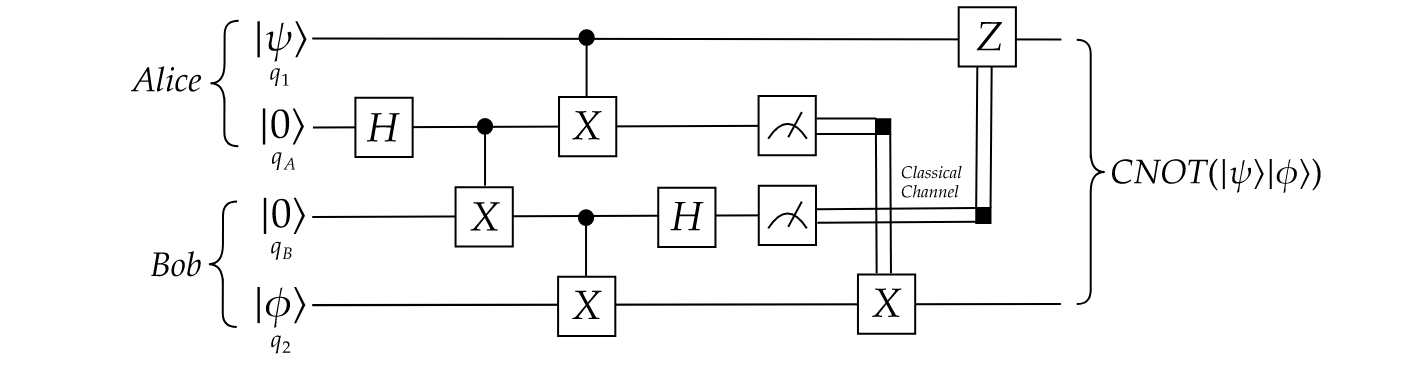


# Implementation of non-local $CNOT$

Now, we move on to constructing this circuit using TheQ.

Since the circuit contains four qubits, we create a circuit with four qubits.

In [ ]:
# Prepare the circuit
reg_id = create_circuit(4,0)

Now, we shall start applying the gates.

The first step is to prepare arbitrary states in the first and last qubits. Lets start by generating arbitray normalized complex vectors in two dimensions, by applying a $R_X(\theta)$ and $R_Z(\omega)$ gates on $|0\rangle$, with random values of $\theta$ and $\omega$. 

In [ ]:
# Apply rotation around x-axis followed by rotation around z-axis on qubits 0 and 3.
gate(reg_id, 'xrot', {'q': 0, 'theta': 13})
gate(reg_id, 'zrot', {'q': 0, 'theta': 19})

gate(reg_id, 'xrot', {'q': 3, 'theta': 23})
gate(reg_id, 'zrot', {'q': 3, 'theta': 29})

True

Next step is to prepare $|\beta\rangle = \frac{1}{\sqrt{2}}\Big( |00\rangle + |11\rangle\Big)$ in the second and third qubit. This is done by applying an $H$ gate followed by a $CNOT$ gate.

In [ ]:
# Apply Hadamard gate on qubit 1 
gate(reg_id, 'hadamard', {'q': 1})

# Apply CNOT gate on qubits 1 and 2
gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 2})

True

Alice applies a $CNOT$ gate on the first and second qubits. Then Bob applies a $CNOT$ gate on the third and fourth qubits.

In [ ]:
# Apply CNOT gate on qubits 0 and 1
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

# Apply CNOT gate on qubits 2 and 3
gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})

True

Now, Bob applies a Hadamard gate on the qubit in his possession (third qubit).


In [ ]:
# Apply Hadamard gate on qubit 2
gate(reg_id, 'hadamard', {'q': 2})

True

Now, Alice and Bob measures the qubits in which they had the Bell state, and applies $X$ gate and $Z$ gate based on the result of the measurements. That is, we measure qubits $q_1$ and $q_2$. If $q_1$ resulted in $1$, we apply a $X$ gate on the last qubit. Then, if $q_2$ resulted in $1$, then we apply a $Z$ gate on the first qubit.

In [ ]:
# Measure qubits 1 and 2
c1 = measure_qubit(reg_id,{'lq2m': [1]})
c2 = measure_qubit(reg_id,{'lq2m': [2]})

# Apply CNot gate followed by CZ gate on qubit 2
gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
gate(reg_id, 'cphase', {'q_control': 2, 'q_target': 0, 'theta': np.pi})

True

Now, let's extract the state at this point.

In [ ]:
print_vector(reg_id)

[{'binary_pattern': '0110',
  'complex_value': {'im': 0.4274234301661436, 're': -0.20020801503992083},
  'state': 6},
 {'binary_pattern': '0111',
  'complex_value': {'im': -0.17054509289113612, 're': -0.07988447079108647},
  'state': 7},
 {'binary_pattern': '1110',
  'complex_value': {'im': 0.2425186195594749, 're': -0.8198378327150115},
  'state': 14},
 {'binary_pattern': '1111',
  'complex_value': {'im': -0.029491935885210006, 're': -0.09969793182321467},
  'state': 15}]

In [ ]:
# Extract the statevector
non_local_output = np.zeros(4) + (1j * np.zeros(4))
for i in range(4):
  non_local_output[i] = print_vector(reg_id)[i]['complex_value']['re'] + (1j * print_vector(reg_id)[i]['complex_value']['im'])

Remember to destroy the circuit after use. 

In [ ]:
# Destroy circuit
destroy_circuit(reg_id)

Next step is to verify if we really did end up with $CNOT(|\psi \rangle |\phi \rangle)$. For that, we compute the fidelity between the "non_local_output" and "local_output" which is $CNOT (|\psi\rangle |\phi \rangle)$ computed separately, that is, 

\begin{equation}
  \Big| \langle \text{non_local_output}, \text{local_output} \rangle \Big|
\end{equation}

If this output is $1$, our circuit seems to be doing the job.

In [ ]:
# Prepare the circuit
reg_id = create_circuit(2,0)

# Apply rotation around x-axis followed by rotation around z-axis on qubits 0 and 3.
gate(reg_id, 'xrot', {'q': 0, 'theta': 13})
gate(reg_id, 'zrot', {'q': 0, 'theta': 19})

gate(reg_id, 'xrot', {'q': 1, 'theta': 23})
gate(reg_id, 'zrot', {'q': 1, 'theta': 29})

# Apply CNOT gate on qubits 0 and 1
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

# Extract the statevector
local_output = np.zeros(4) + (1j * np.zeros(4))
for i in range(4):
  local_output[i] = print_vector(reg_id)[i]['complex_value']['re'] + (1j * print_vector(reg_id)[i]['complex_value']['im'])

# Display fidleity of output
print("fidleity of output: {}".format(np.abs(np.dot(np.conj(local_output), non_local_output))))

# Destroy circuit
destroy_circuit(reg_id)

fidleity of output: 0.9999999999999999


As expected, the result is $1$. Now, let's run this non-local $CNOT$ protocol multiple times and observe the result. 

In [ ]:
for i in range(20):
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Apply rotation around x-axis followed by rotation around z-axis on qubits 0 and 3.
  gate(reg_id, 'xrot', {'q': 0, 'theta': 13})
  gate(reg_id, 'zrot', {'q': 0, 'theta': 19})

  gate(reg_id, 'xrot', {'q': 3, 'theta': 23})
  gate(reg_id, 'zrot', {'q': 3, 'theta': 29})

  # Apply Hadamard gate on qubit 1 
  gate(reg_id, 'hadamard', {'q': 1})

  # Apply CNOT gate on qubits 1 and 2
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 2})

  # Apply CNOT gate on qubits 0 and 1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply CNOT gate on qubits 2 and 3
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})

  # Apply Hadamard gate on qubit 2
  gate(reg_id, 'hadamard', {'q': 2})

  # Measure qubits 1 and 2
  c1 = measure_qubit(reg_id,{'lq2m': [1]})
  c2 = measure_qubit(reg_id,{'lq2m': [2]})

  # Apply CNot gate followed by CZ gate on qubit 2
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cphase', {'q_control': 2, 'q_target': 0, 'theta': np.pi})

  # Extract the statevector
  non_local_output = np.zeros(4) + (1j * np.zeros(4))
  for i in range(4):
    non_local_output[i] = print_vector(reg_id)[i]['complex_value']['re'] + (1j * print_vector(reg_id)[i]['complex_value']['im'])

  # Destroy circuit
  destroy_circuit(reg_id)

  # Prepare the circuit
  reg_id = create_circuit(2,0)

  # Apply rotation around x-axis followed by rotation around z-axis on qubits 0 and 3.
  gate(reg_id, 'xrot', {'q': 0, 'theta': 13})
  gate(reg_id, 'zrot', {'q': 0, 'theta': 19})

  gate(reg_id, 'xrot', {'q': 1, 'theta': 23})
  gate(reg_id, 'zrot', {'q': 1, 'theta': 29})

  # Apply CNOT gate on qubits 0 and 1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Extract the statevector
  local_output = np.zeros(4) + (1j * np.zeros(4))
  for i in range(4):
    local_output[i] = print_vector(reg_id)[i]['complex_value']['re'] + (1j * print_vector(reg_id)[i]['complex_value']['im'])

  # Display fidleity of output
  print("fidleity of output: {}".format(np.abs(np.dot(np.conj(local_output), non_local_output))))

  # Destroy circuit
  destroy_circuit(reg_id)



fidleity of output: 0.9999999999999999
fidleity of output: 1.0
fidleity of output: 1.0
fidleity of output: 1.0
fidleity of output: 0.9999999999999999
fidleity of output: 1.0
fidleity of output: 1.0
fidleity of output: 1.0
fidleity of output: 1.0
fidleity of output: 1.0
fidleity of output: 0.9999999999999999
fidleity of output: 0.9999999999999999
fidleity of output: 0.9999999999999999
fidleity of output: 1.0


JSONDecodeError: ignored

As the result is 1 always, we can safely assume that our circuit is indeed a non-local $CNOT$ protocol.